In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

In [2]:
torch.manual_seed(123)

In [3]:
args = {
    "lr": 0.001,
    "batch_size": 16,
    "epochs": 10
}

In [4]:
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')
    
# args['device'] = torch.device('cpu')
#print(args['device'])

## Parâmetros

In [5]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 16

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [6]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Cubone/fefbed48b15c494fb236de3cb...,Cubone
1,./PokemonData/Onix/ab39e2116e27456e8ff250c4a67...,Onix
2,./PokemonData/Doduo/067337c9f06840808a258ce7ef...,Doduo
3,./PokemonData/Onix/06941adc42384689bc8c2b27851...,Onix
4,./PokemonData/Mewtwo/00000002.jpg,Mewtwo
...,...,...
6820,./PokemonData/Slowbro/3dcf5dcadcc2480dbf8d197d...,Slowbro
6821,./PokemonData/Kabutops/082f63cfd92c4520975e696...,Kabutops
6822,./PokemonData/Cubone/3eb3a9e174604e0cba3b8409f...,Cubone
6823,./PokemonData/Slowbro/Screen Shot 2019-08-12 a...,Slowbro


## Analisando Dados

In [7]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


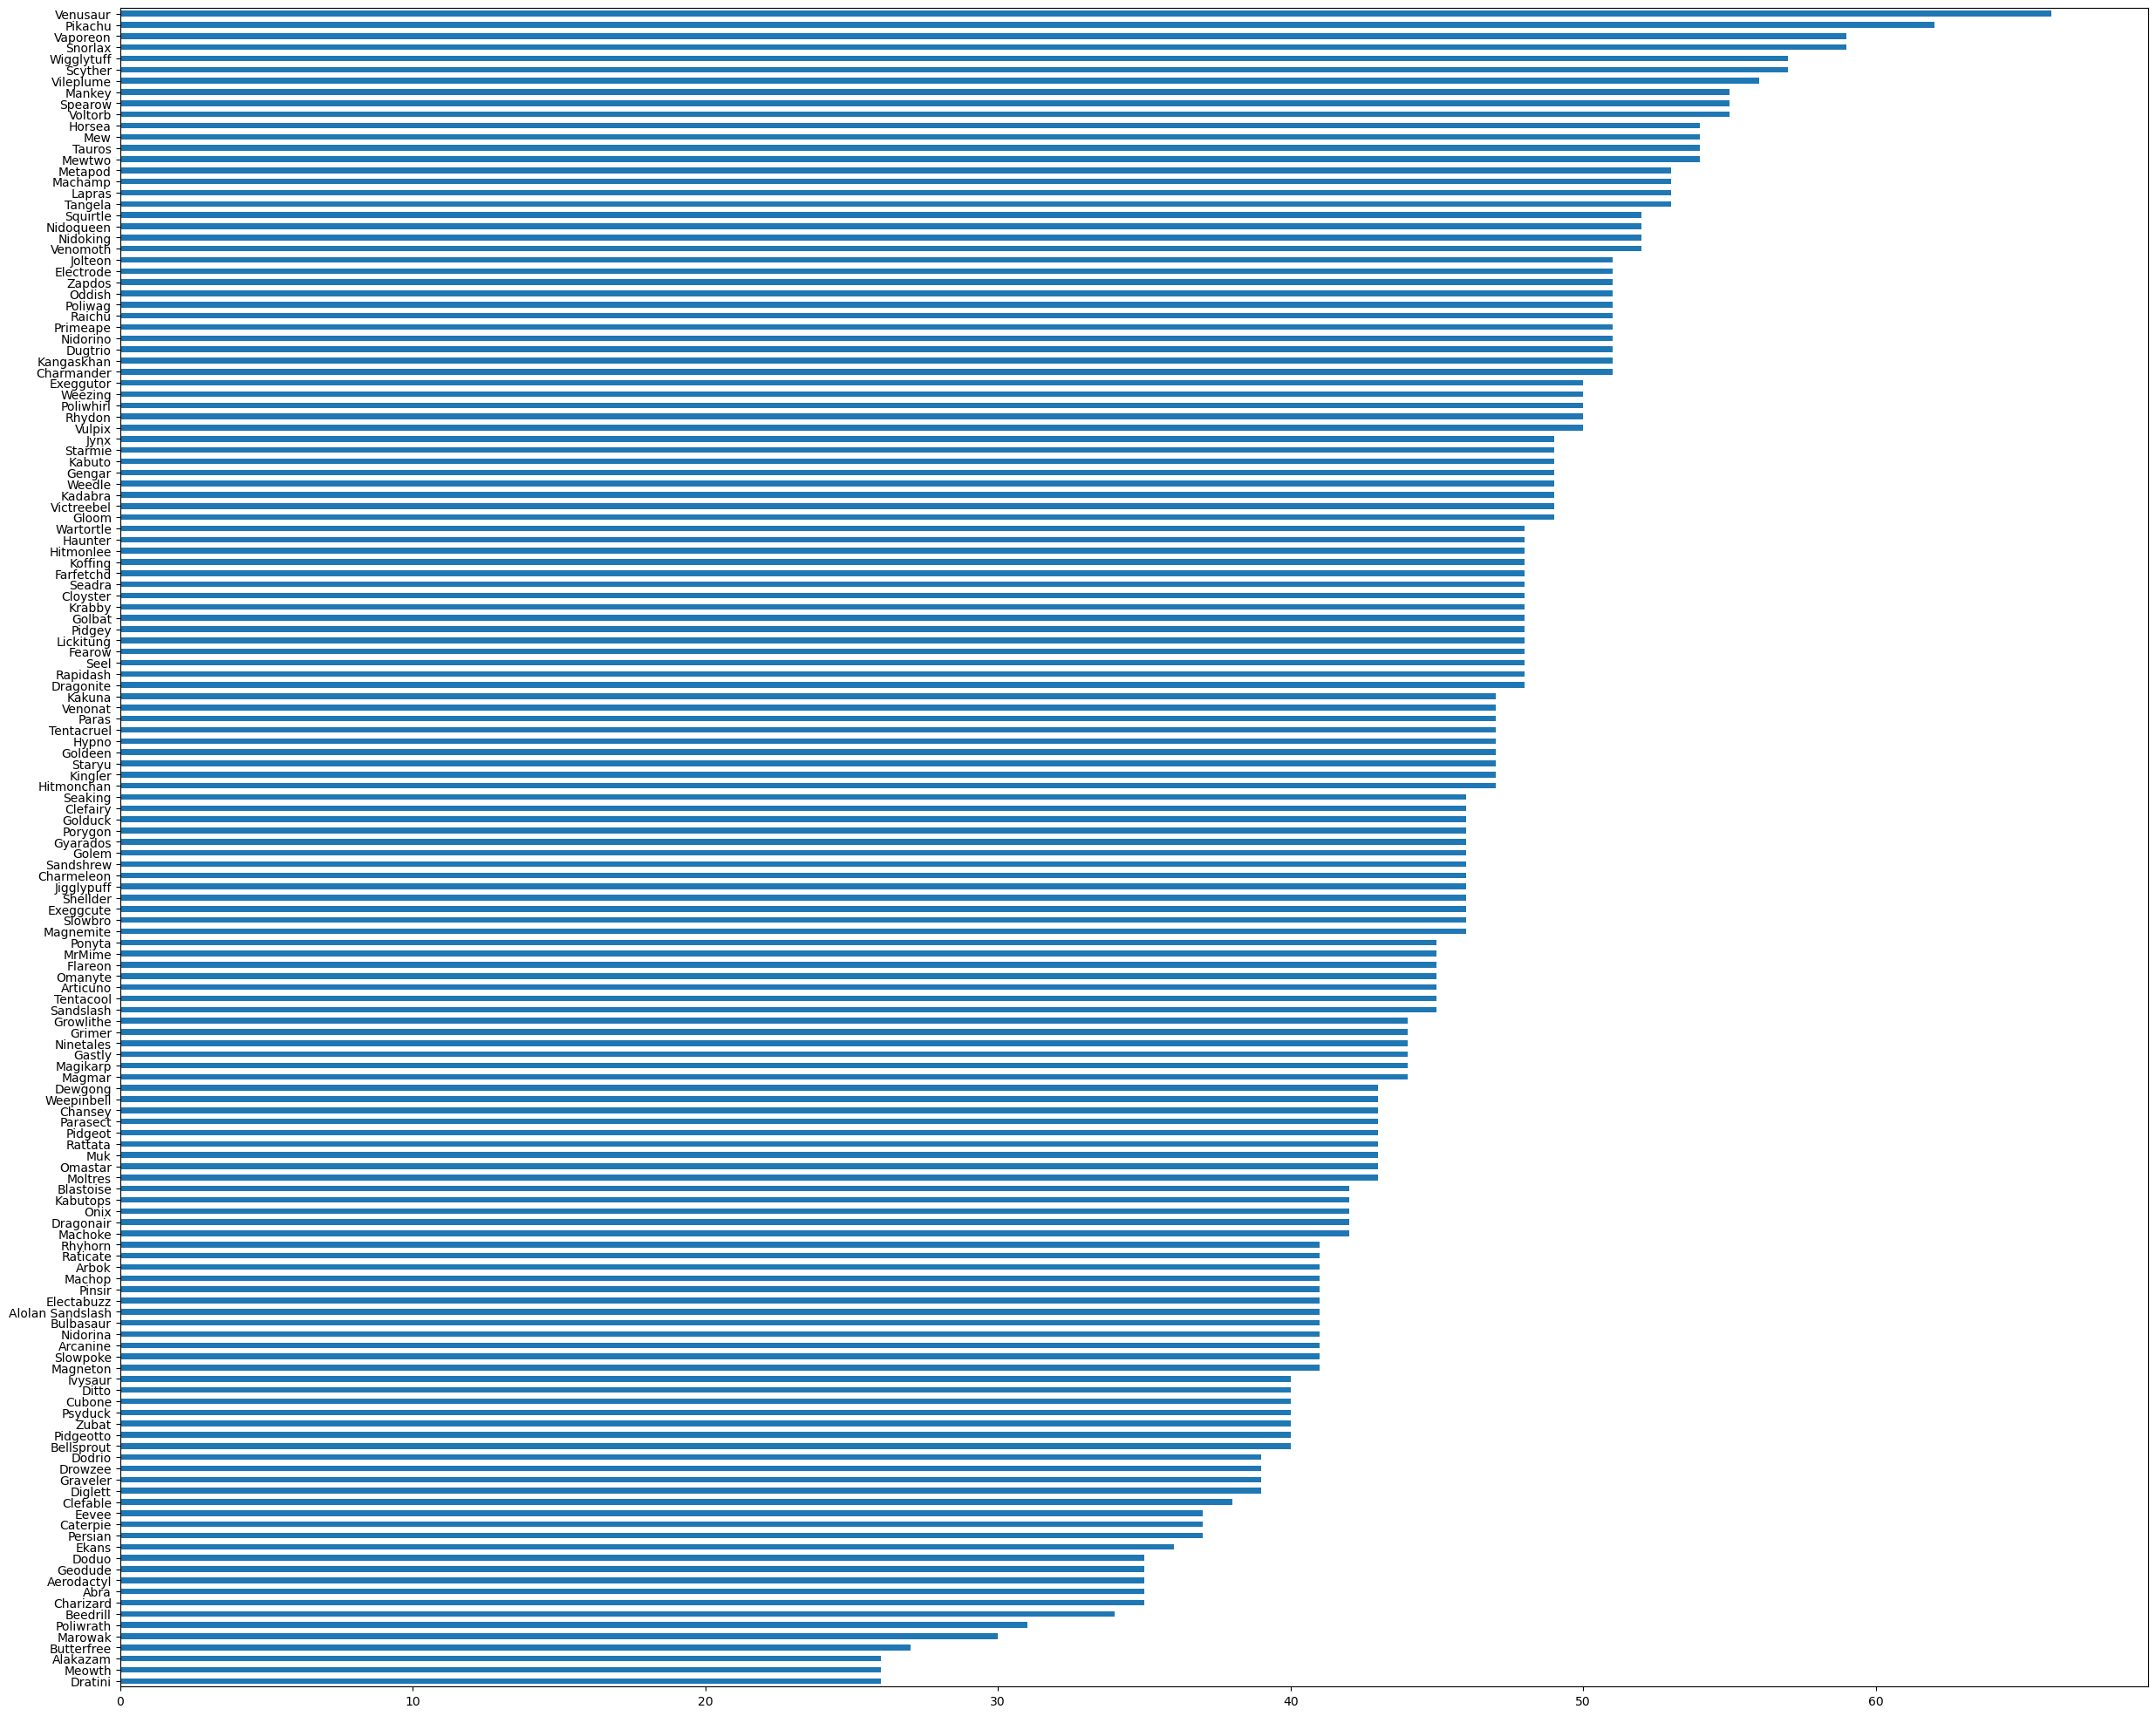

In [8]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [9]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

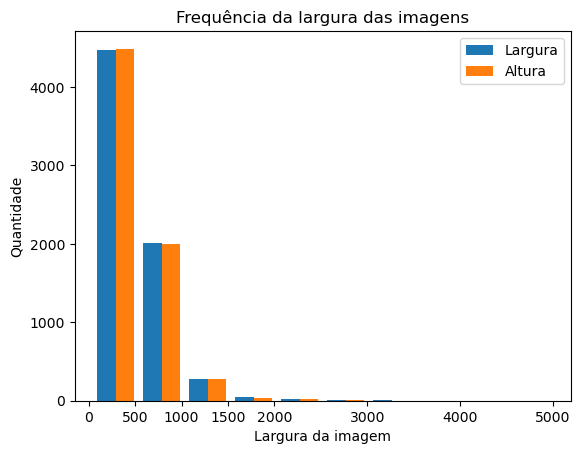

In [10]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [11]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [12]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [13]:
percentil40_width = np.percentile(widths, 40)
percentil40_height = np.percentile(heights, 40)

print(f"Percentil 40 em relação a \nwidth: {percentil40_width} \nheight: {percentil40_height}")

Percentil 40 em relação a 
width: 287.0 
height: 286.0


In [14]:
print(f"Tamanho da menor imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da menor imagem em relação a 
width: 43 
height: 42


In [15]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [16]:
# largura = math.floor(mean_width)
# altura = math.floor(mean_height)
largura = int(min(percentil40_width, percentil40_height))
altura = int(min(percentil40_width, percentil40_height))

print(f"Largura e altura escolhidas, respectivamente: {largura}, {altura}")

Largura e altura escolhidas, respectivamente: 286, 286


In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Usando deep learning com pytorch

In [18]:
train_transforms =  transforms.Compose([
        transforms.Resize((largura, altura)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(40),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

val_transforms = transforms.Compose([
        transforms.Resize((largura, altura)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((largura, altura)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [19]:
x_train_balanced, x_val_balanced, y_train_balanced, y_val_balanced = train_test_split(df_dados['image'], df_dados['target'], test_size=0.30, stratify=df_dados['target'])

x_val_balanced, x_test_balanced, y_val_balanced, y_test_balanced = train_test_split(x_val_balanced, y_val_balanced, test_size=0.50, stratify=y_val_balanced)

In [20]:
df_dados_train = pd.DataFrame({'image': x_train_balanced, 'target': y_train_balanced})

df_dados_train

,image,target
777,./PokemonData/Hitmonlee/ef0b3f4fbf1c4289b02c8f...,Hitmonlee
5418,./PokemonData/MrMime/a4fa1236d517444d8acf2b054...,MrMime
1909,./PokemonData/Venusaur/d0a9193c60c7451f88fbf1e...,Venusaur
6219,./PokemonData/Rhydon/eba683963af84dcf9ce71cf9a...,Rhydon
2241,./PokemonData/Nidoqueen/df589aeb4b8f4da095f5cb...,Nidoqueen
...,...,...
2219,./PokemonData/Oddish/00fd8c607c3d45e0a87d8d01e...,Oddish
4402,./PokemonData/Exeggutor/c5c77a423e544854805273...,Exeggutor
5127,./PokemonData/Doduo/1683c88022fd4baf943753d65d...,Doduo
1148,./PokemonData/Magikarp/efd8df8d8fb94b7d89df7db...,Magikarp


In [21]:
df_dados_val = pd.DataFrame({'image': x_val_balanced, 'target': y_val_balanced})

df_dados_val

,image,target
3420,./PokemonData/Eevee/d4e942a56e6c4643b4a38173d2...,Eevee
6333,./PokemonData/Poliwrath/f2688e1bc13f4d1b92db14...,Poliwrath
1616,./PokemonData/Kakuna/ad0d8870fcd84d5bbcdabd791...,Kakuna
4002,./PokemonData/Machop/65d336643e7c479fafd2a8f6e...,Machop
5661,./PokemonData/Nidoqueen/c407cbb563f849fb994c4d...,Nidoqueen
...,...,...
2831,./PokemonData/Nidoqueen/49586fc24ba14cff9429d3...,Nidoqueen
4967,./PokemonData/Tentacruel/9e2e6a0a82904f64879fb...,Tentacruel
2117,./PokemonData/Arbok/f8f3a75c630f4826a7b5bda5d0...,Arbok
6263,./PokemonData/Staryu/40e8bd70eef046aca7c3b1f8c...,Staryu


In [22]:
df_dados_test = pd.DataFrame({'image': x_test_balanced, 'target': y_test_balanced})

df_dados_test

,image,target
1587,./PokemonData/Omanyte/e450558e243443199b05cddf...,Omanyte
260,./PokemonData/Vileplume/f6de0b2a2d3342f68d6667...,Vileplume
2969,./PokemonData/Omanyte/5e30226f06e741c2abae09d5...,Omanyte
3153,./PokemonData/Nidorino/03f8935c158941cf9c0aeb6...,Nidorino
6078,./PokemonData/Ditto/b49b0de9757a4f4198eebc6643...,Ditto
...,...,...
2785,./PokemonData/Ponyta/42dfaaf1b76e48a0b28c000b1...,Ponyta
3430,./PokemonData/Charizard/c654cf3d2ec8453db1a0d6...,Charizard
1352,./PokemonData/Zubat/283a53c127a749b29801bb9f76...,Zubat
50,./PokemonData/Farfetchd/38b2a8c41abe4d11885ef7...,Farfetchd


In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.encode = {k: i for i, k in enumerate(dataframe['target'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image']
        #target = self.dataframe.iloc[idx]['target']
        
        #target = self.encode[self.dataframe['target'].tolist().index(self.dataframe.iloc[idx]['target'])]
        target = self.encode.get(self.dataframe.iloc[idx]['target'])

        # Carregar a imagem usando PIL
        image = Image.open(image_path)

        # Aplicar transformações, se fornecidas
        if self.transform:
            image = self.transform(image)

        return image, target


In [24]:
dataset_train = CustomDataset(df_dados_train, transform=train_transforms)
dataset_val = CustomDataset(df_dados_val)
dataset_test = CustomDataset(df_dados_test)

In [25]:
train_set = DataLoader(dataset=dataset_train, shuffle=True, batch_size=args['batch_size'])
val_set = DataLoader(dataset=dataset_val, shuffle=False, batch_size=args['batch_size'])
test_set = DataLoader(dataset=dataset_test, shuffle=False, batch_size=args['batch_size'])

In [26]:
model = models.resnext50_32x4d(pretrained=True)
newmodel = nn.Sequential(*(list(model.children())[:-1]))
for param in newmodel.parameters():
    param.requires_grad = False

C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# newmodel

In [28]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer0 = nn.Sequential(
            newmodel,
            #nn.AvgPool2d(3)
        )
        
        #self.layer1 = nn.Sequential(
        #    nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.MaxPool2d(2)
        #)
        
        #self.layer2 = nn.Sequential(
         #   nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
          #  nn.BatchNorm2d(32),
           # nn.ReLU(),
            #nn.MaxPool2d(2)
            #)
        
        #self.layer3 = nn.Sequential(
            #nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
           # nn.BatchNorm2d(64),
          #  nn.ReLU(),
         #   nn.MaxPool2d(2)
        #)
        
        self.flatten = nn.Flatten()
        #self.batchnorm2d = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(2048,512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        self.fc2 = nn.Linear(512,150)

        self.softmax = nn.Softmax(150)
        
    def forward(self,x):
        out = self.layer0(x)
        #out = self.layer1(out)
        #out = self.layer2(out)
        #out = self.layer3(out)
        out = out.view(out.size(0),-1)
        #out = self.flatten(out)
        #out = self.batchnorm2d(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [29]:
model = Cnn().to(args['device'])
model.train()

Cnn(
  (layer0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [30]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
epochs = 15

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in train_set:
        data = data.to(args['device'])
        label = label.to(args['device'])
        output = model(data)
        loss = criterion(output, label)
        #print(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_set)
        epoch_loss += loss/len(train_set)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_set:
            data = data.to(args['device'])
            label = label.to(args['device'])
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
              
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_set)
            epoch_val_loss += val_loss/ len(val_set)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    
    print()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2048 and 1024x512)